<a href="https://colab.research.google.com/github/mnrazamohamed/Finance_Loan_Approval_Prediction_Data/blob/main/Finance_Loan_Approval_Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finance Loan Approval Prediction Data**

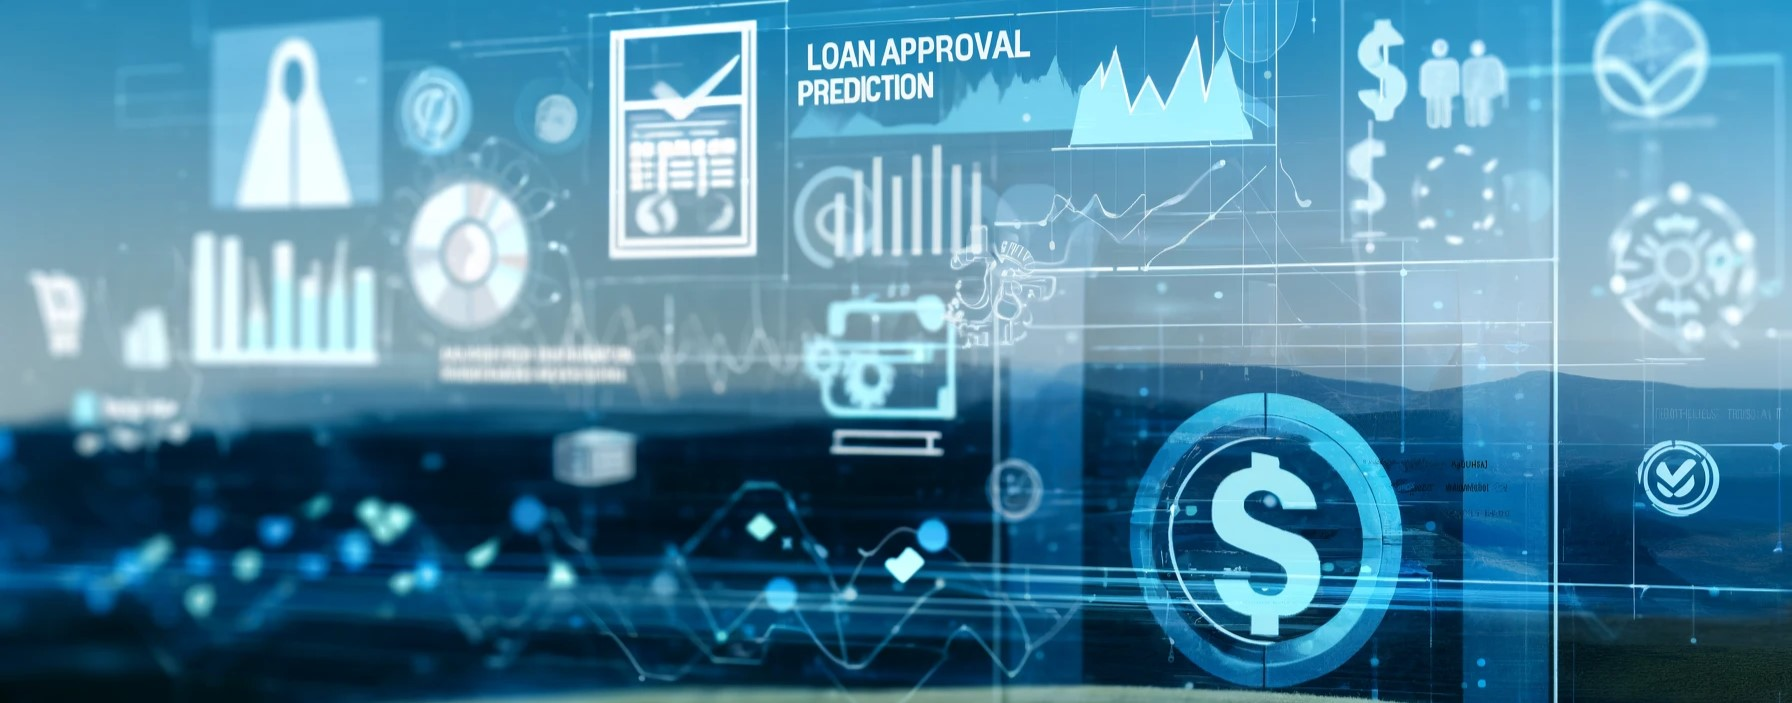

## **Introduction**
This project is focused on predicting loan approval based on a set of features such as gender, marital status, dependents, education, credit history, and property area. The goal is to create a machine learning model that can accurately predict whether a loan application will be approved or not.

### **Features Description**

1. **Loan_ID**: A unique identifier for each loan in the dataset.
2. **Gender**: Categorical variable indicating the gender of the applicant (Male/Female).
3. **Married**: Binary variable indicating the marital status of the applicant (Yes/No).
4. **Dependents**: The number of dependents the applicant has (0, 1, 2, 3+).
5. **Education**: Binary variable indicating the education level of the applicant (Graduate/Not Graduate).
6. **Self_Employed**: Binary variable indicating whether the applicant is self-employed (Yes/No).
7. **ApplicantIncome**: The income of the loan applicant.
8. **CoapplicantIncome**: The income of the coapplicant (if applicable).
9. **LoanAmount**: The amount of loan requested by the applicant (in thousands).
10. **Loan_Amount_Term**: The term of the loan in months (typically 360 months for 30 years).
11. **Credit_History**: Binary variable indicating whether the applicant has a credit history (1 = Yes, 0 = No).
12. **Property_Area**: Categorical variable representing the area of the property (Urban/Semiurban/Rural).
13. **Loan_Status**: Target variable indicating whether the loan was approved (1 = Approved, 0 = Not Approved).


## **Classes and Model Setup**

In this section, we introduce the key classes used for data preprocessing, analysis, and model evaluation. These classes handle various tasks such as loading and preparing the dataset, performing exploratory data analysis (EDA), and evaluating the performance of multiple machine learning models. By structuring the workflow into classes, we ensure the code is modular, reusable, and easy to manage for different steps in the loan approval prediction process.

### **DataHandler Class for Dataset Preprocessing**

**Description**:
This cell implements the `DataHandler` class, which is designed to streamline the process of handling and preprocessing datasets for machine learning tasks. The class provides a variety of methods for managing the dataset, including:

1. **Loading Data**: The `load_data` method loads the dataset from a CSV file into a pandas DataFrame.
2. **Setting Categorical Columns**: The `set_categorical_columns` method allows you to specify which columns are categorical.
3. **Handling Missing Values**: The `drop_na_rows` method drops rows containing missing values to clean the dataset.
4. **Dropping Unnecessary Columns**: The `drop_columns` method removes specified columns from the dataset.
5. **Encoding Categorical Data**: The `encode_data` method encodes categorical variables into numerical values based on a provided mapping.
6. **Outlier Detection**: The `find_outliers_below_one_percent_and_llul` method identifies outliers using the Interquartile Range (IQR) and frequency analysis.
7. **Outlier Handling**: The `handle_outliers` and `cap_values_all` methods cap the detected outliers in the dataset to limit their influence on the model.
8. **Data Splitting**: The `split_data` method splits the dataset into training and testing sets, allowing you to define the target class and test size.
9. **Class Balancing**: The `balance_classes` method balances imbalanced datasets by oversampling the minority class using the `RandomOverSampler` from the `imblearn` library.
10. **Retrieving the Processed Data**: The `get_data` method returns the processed dataset after all transformations.

This class automates the repetitive tasks involved in data cleaning, outlier handling, and class balancing, making it easier to prepare data for machine learning models.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataHandler:
    def __init__(self, dataset_path):
        """
        Initialize the DataHandler class with the path to the dataset.
        """
        self.dataset_path = dataset_path
        self.data = None

    def load_data(self):
        """
        Loads the dataset into a DataFrame.
        """
        try:
            self.data = pd.read_csv(self.dataset_path)
            print("Dataset loaded successfully!")
        except FileNotFoundError as e:
            print(f"Error: {e}. Please provide the correct file path.")
        return self.data

    def set_categorical_columns(self, categorical_columns):
        """
        Sets the list of categorical columns.
        """
        self.categorical_columns = categorical_columns

    def drop_na_rows(self):
        """
        Drops rows with missing values from the dataset.
        """
        print("Dropping rows with missing values...")
        self.data.dropna(inplace=True)

    def drop_columns(self, columns):
        """
        Drops specified columns from the dataset.
        """
        print(f"Dropping columns: {columns}")
        self.data.drop(columns, axis=1, inplace=True)

    def encode_data(self, data_map):
        """
        Encodes categorical variables into numerical values.
        """
        print("Encoding categorical variables...")
        self.data_map = data_map
        self.data.replace(data_map, inplace=True)

    def find_outliers_below_one_percent_and_llul(self, most_value_count, col):
        """
        Identifies outliers using IQR and filters values below 1% frequency.
        """
        a = self.data[col].value_counts()[self.data[col].value_counts() < (most_value_count / 100)]

        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1

        ll = Q1 - 1.5 * IQR  # Lower limit
        ul = Q3 + 1.5 * IQR  # Upper limit

        # Filter values that are either below the lower limit or above the upper limit
        a = a[(a.index > ul) | (a.index < ll)]
        return (col, a.index.to_list(), ll, ul)

    def cap_values_all(self, col_value_pairs):
        """
        Caps the values in the columns to limit outliers.
        """
        for col, values, ll, ul in col_value_pairs:
            self.data[col] = self.data[col].clip(lower=ll, upper=ul)
        return self.data

    def outlier_founder(self):
        """
        Identifies and handles outliers for numerical columns.
        """
        process_cols = [col for col in self.data.columns
                        if col not in self.categorical_columns and col != "Loan_Status"]

        outliers = []
        for col in process_cols:
            index = self.data[col].value_counts().index[0]
            value = self.data[col].value_counts()[index]
            outliers.append(self.find_outliers_below_one_percent_and_llul(value, col))
        return outliers

    def handle_outliers(self):
        """
        Detects and caps outliers in the dataset.
        """
        print("Detecting outliers...")
        outliers = self.outlier_founder()
        self.data = self.cap_values_all(outliers)
        print("Outliers handled:", outliers)


    def split_data(self, class_variable, test_size=0.2, random_state=42):
        """
        Splits the dataset into training and testing sets.
        """
        x = self.data.drop(class_variable, axis=1)
        y = self.data[class_variable]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=random_state)
        print("Data split into train and test sets.")
        return x_train, x_test, y_train, y_test

    def balance_classes(self, x_train, y_train, random_state=123):
        """
        Balances the classes in the training data using RandomOverSampler.
        """
        ros = RandomOverSampler(random_state=random_state)
        x_res, y_res = ros.fit_resample(x_train, y_train)

        print('Before oversample:', sum(y_train == 1), sum(y_train == 0))
        print('After oversample:', sum(y_res == 1), sum(y_res == 0))

        return x_res, y_res

    def get_data(self):
        """
        Returns the processed dataset.
        """
        return self.data


### **Exploratory Data Analysis (EDA) Class**

This cell implements an `EDA` (Exploratory Data Analysis) class, which is designed to assist in performing various exploratory data analysis tasks on a dataset. It includes the following functionalities:

1. **Displaying Data**:
   - `display_data`: Displays the first few rows of the dataset.
   - `display_columns`: Displays the column names.
   - `display_shape`: Displays the shape of the dataset.
   - `check_data_types`: Displays the data types of each column.
   - `check_missing_values`: Displays the count of missing values per column.
   - `check_duplicates`: Checks for duplicate rows based on the "Loan_ID" column.
   
2. **Loan Status Distribution**:
   - `loan_status_distribution`: Displays the count and percentage of loan approval statuses (Approved vs. Not Approved).
   
3. **Summary Statistics**:
   - `describe_data`: Generates summary statistics for the numerical columns in the dataset.
   
4. **Visualization**:
   - `plot_bar_plots`: Generates bar plots for categorical columns, providing visual distributions for different categorical variables.
   - `plot_correlation_heatmap`: Plots a correlation heatmap of the numerical features to display relationships between them.
   - `plot_histograms`: Creates histograms for numerical features to visualize the distribution, including a probability density function (PDF) overlay.
   - `plot_boxplots`: Generates boxplots for numerical columns to identify the spread and potential outliers in the data.

This class simplifies the process of performing EDA by offering a set of methods for both basic data exploration and advanced visualization, allowing users to understand the structure, distribution, and relationships within the dataset. The `EDA` class is especially useful for gaining insights into the dataset, identifying trends, and preparing for machine learning model development by visualizing distributions and relationships among variables.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np


class EDA:
    def __init__(self, data):
        """
        Initialize the EDA class with the dataset.
        """
        self.data = data

    def display_data(self, num_rows=5):
        """Displays the first few rows of the dataset."""
        print(f"First {num_rows} rows of the dataset:")
        return self.data.head(num_rows)

    def display_columns(self):
        """Displays the column names of the dataset."""
        print("Column names:")
        print(self.data.columns.tolist())

    def display_shape(self):
        """Displays the shape of the dataset."""
        print(f"Dataset shape: {self.data.shape}")

    def check_data_types(self):
        """Displays the data types of each column."""
        print("\nData Types:")
        return self.data.dtypes

    def check_missing_values(self):
        """Displays the count of missing values per column."""
        print("\nMissing Values in Each Column:")
        return self.data.isna().sum()

    def check_duplicates(self):
        """Checks for duplicate rows based on Loan_ID."""
        duplicates = self.data[self.data.duplicated(subset="Loan_ID", keep=False)]
        print(f"\nNumber of duplicate entries: {len(duplicates)}")
        if len(duplicates) > 0:
            print(duplicates)

    def loan_status_distribution(self):
        """Displays the count and percentage of loan approval statuses."""
        print("\nLoan Status Distribution:")
        print(self.data['Loan_Status'].value_counts())

        print("\nLoan Status Distribution (%):")
        print(self.data['Loan_Status'].value_counts(normalize=True) * 100)

    def describe_data(self):
        """Generates summary statistics for numerical columns."""
        print("\nSummary Statistics:")
        return self.data.describe()

    def plot_bar_plots(self, categorical_columns):
        """Generates bar plots for each categorical column."""

        # Mapping the 0 and 1 values in Credit_History to "Does Not Comply" and "Complies"
        self.data["Credit_History"] = self.data["Credit_History"].map({0.0: "Does Not Comply", 1.0: "Complies"})
        fig, axes = plt.subplots(2, 4, figsize=(20, 7))
        axes = axes.flatten()

        for i, col in enumerate(categorical_columns):
            sns.countplot(x=col, data=self.data, ax=axes[i])
            axes[i].set_title(f"{col} Distribution")

        for j in range(len(categorical_columns), len(axes)):
            axes[j].axis('off')  # Turn off unused plots

        plt.tight_layout()
        plt.show()
        self.data["Credit_History"] = self.data["Credit_History"].map({"Does Not Comply": 0.0, "Complies": 1.0})

    def plot_correlation_heatmap(self):
        """Plots a correlation heatmap of the numerical features."""
        cor = self.data.corr()
        plt.figure(figsize=(18, 8))
        sns.heatmap(cor, annot=True, fmt='.2f')
        plt.title("Correlation Heatmap")
        print(plt.show())

        cor = self.data.corr()
        cor = round(cor, 2)
        cor = cor[cor == 0]
        sns.heatmap(cor, annot=True, fmt='.2f')
        plt.title("Correlation Heatmap")
        print(plt.show())

        cor = self.data.corr()
        cor = round(cor, 2)
        cor = cor.drop([c for c in cor.columns if c not in ["Loan_ID","Loan_Status"]],axis=1)
        sns.heatmap(cor, annot=True,fmt='.2f' )
        plt.title("Correlation Heatmap")
        print(plt.show())

    def plot_histograms(self, categorical_columns):
        """Generates histograms for numerical features."""
        # Create a 1x4 grid layout
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Flatten the 1x4 grid into a 1D array for easier iteration
        axes = axes.flatten()

        # Set the main title for the entire figure
        fig.suptitle("Histogram Plot", fontsize=16)

        # Define the categorical and processed columns
        process_cols = [c for c in self.data.columns.to_list() if c not in categorical_columns and c not in ['Loan_ID','Loan_Status']]

        # Loop through DataFrame columns and plot
        for i, (col, ax) in enumerate(zip(process_cols, axes)):
            # Plot histogram
            sns.histplot(self.data[col], bins=30, kde=False, ax=ax, color='skyblue', edgecolor='skyblue',stat='density')

            # Calculate mean and standard deviation
            mu, std = self.data[col].mean(), self.data[col].std()

            # Generate smooth curve based on mean and standard deviation
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std) #probability densitiy function

            # Plot smooth curve
            ax.plot(x, p , 'r--')

            # Set title and labels
            ax.set_title(f'{col} (mean={mu:.2f}, std={std:.2f})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')

        plt.tight_layout()
        plt.show()

    def plot_boxplots(self, categorical_columns):
        """Generates boxplots for numerical columns."""
        # Create a 1x4 grid layout
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Flatten the 1x4 grid into a 1D array for easier iteration
        axes = axes.flatten()

        # Set the main title for the entire figure
        fig.suptitle("Box Plot", fontsize=16)

        # Define the categorical and processed columns
        process_cols = [c for c in self.data.columns.to_list() if c not in categorical_columns and c not in ['Loan_ID','Loan_Status']]

        # Loop through DataFrame columns and plot
        for i, col in enumerate(process_cols):
            sns.boxplot(x=col, data=self.data, ax=axes[i])

        # Remove any remaining empty subplots
        for i in range(len(process_cols), len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()


### **Model Evaluation and Performance Metrics**


This cell defines the `EvaluationManager` class, which simplifies the process of evaluating machine learning models. It provides methods to compute key performance metrics, generate evaluation reports, and visualize these metrics for better insight into model performance. Additionally, it allows comparison of these metrics across multiple models.

Key functionalities include:

1. **Basic Evaluation**:
   - `get_basic_scores`: Computes various metrics like training and validation accuracy, accuracy difference, precision, recall, F1-score, and the confusion matrix for the model.
   - `print_evaluation_report`: Displays a comprehensive evaluation report for a given model, including all computed metrics and a formatted confusion matrix.

2. **Performance Plotting**:
   - `plot_performance_metrics`: Generates bar plots showing key performance metrics (e.g., accuracy, precision, recall) for a given model.
   - `plot_model_metric_comparison`: Compares a specific metric (e.g., accuracy, F1-score) across multiple models.
   - `plot_all_metrics`: Generates comparison plots for several metrics (e.g., accuracy, precision, recall) across all models in `model_scores`.

This class assists with both evaluating individual models and comparing their performance across multiple models, making it a valuable tool for model selection and refinement.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

class EvaluationManager:
    def __init__(self):
        """
        Initialize the EvaluationManager with an empty dictionary for model scores.
        """
        self.model_scores = {}

    def get_conf_matrix(self, y_test, y_pred):
        """
        Computes and returns the confusion matrix as a formatted string.
        """
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP = conf_matrix[1, 1]
        TN = conf_matrix[0, 0]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]

        return f"""
                  Predicted
                  0       1
            0    {TN}      {FP}
    Actual  1    {FN}      {TP}
        """

    def get_basic_scores(self, model, x_train, y_train, x_test, y_test):
        """
        Computes various evaluation metrics for the given model.
        """
        # Predictions for training and test data
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        # Compute training and validation accuracy
        train_accuracy = accuracy_score(y_train, train_pred)
        val_accuracy = accuracy_score(y_test, test_pred)

        # Calculate accuracy difference (training - validation)
        accuracy_diff = train_accuracy - val_accuracy

        # Compute additional metrics for validation data
        precision = precision_score(y_test, test_pred, average='macro')
        recall = recall_score(y_test, test_pred, average='macro')
        f1 = f1_score(y_test, test_pred, average='macro')
        confusion_score = self.get_conf_matrix(y_test, test_pred)

        # Return all the metrics as a dictionary
        return {
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "accuracy_diff": accuracy_diff,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_score": confusion_score
        }

    def print_evaluation_report(self, model_name, info):
        """
        Prints the evaluation metrics for the given model.
        """
        print(f"Model : {model_name}")
        print("Training Accuracy  : {:.4f}".format(info['train_accuracy']))
        print("Validation Accuracy: {:.4f}".format(info['val_accuracy']))
        print("Accuracy Difference: {:.4f}".format(info['accuracy_diff']))
        print("Precision          : {:.4f}".format(info['precision']))
        print("Recall             : {:.4f}".format(info['recall']))
        print("F1 Score           : {:.4f}".format(info['f1']))
        print()
        print("Confusion Matrix")
        print(info['confusion_score'])

        # Plot performance metrics
        self.plot_performance_metrics(model_name, info)

    def plot_performance_metrics(self, model_name, info):
        """
        Plots a bar chart of the performance metrics.
        """
        metrics = ['Training Accuracy', 'Validation Accuracy',
                   'Accuracy Difference', 'Precision', 'Recall', 'F1 Score']
        values = [info['train_accuracy'], info['val_accuracy'],
                  info['accuracy_diff'], info['precision'],
                  info['recall'], info['f1']]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics, values, color='skyblue')
        plt.title(f'{model_name} Performance Metrics')
        plt.ylim(0, 1)  # Adjust if needed
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                     round(bar.get_height(), 4), va='bottom', ha='center')
        plt.xticks(rotation=45)
        plt.show()

    def plot_model_metric_comparison(self, metric):
        """
        Plots a bar chart comparing a specific metric across models.
        """
        # Extracting metric values from model_scores
        metric_values = {model: scores[metric] for model, scores in self.model_scores.items() if metric in scores}

        # Find max and min values
        max_model = max(metric_values, key=metric_values.get)
        min_model = min(metric_values, key=metric_values.get)

        # Assign colors based on metric type and model value
        if metric == 'accuracy_diff':
            values = {model: abs(value) for model, value in metric_values.items()}
            min_model = min(values, key=values.get)
            colors = ['green' if model == min_model else
                      'skyblue' for model in metric_values]
        else:
            colors = ['green' if model == max_model else
                      'skyblue' for model in metric_values]

        # Plotting the comparison chart
        plt.figure(figsize=(10, 3))
        plt.bar(metric_values.keys(), metric_values.values(), color=colors)
        plt.title(f'{metric.capitalize()} Comparison')
        plt.xlabel('Models')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=90)
        plt.show()

    def plot_all_metrics(self):
      """
      Plots bar charts for multiple metrics across all models.
      """
      metrics = ['train_accuracy', 'val_accuracy', 'accuracy_diff',
                'precision', 'recall', 'f1']
      for metric in metrics:
          print(f"Plotting {metric} comparison...")
          self.plot_model_metric_comparison(metric)

### **Installing CatBoost Library**

In this cell, we install the CatBoost library using the `pip` package manager. CatBoost is a popular gradient boosting algorithm that works well with categorical features and offers strong performance for classification and regression tasks. It is particularly useful when dealing with datasets containing both categorical and numerical features, as it automatically handles categorical data without requiring extensive preprocessing.


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00


### **ModelManager Class for Managing and Evaluating Multiple Models**

This cell defines the `ModelManager` class, which is designed to manage, train, and evaluate multiple machine learning models. The `ModelManager` class inherits from the `EvaluationManager`, adding functionality to handle a variety of classification models. Key features include:

1. **Model Storage and Management**:
   - `add_model`: Allows the addition of machine learning models (e.g., KNeighborsClassifier, LogisticRegression, RandomForestClassifier, etc.) to the manager.
   - `get_all_models`: Retrieves all models currently stored in the manager.

2. **Model Training**:
   - `train_model`: Trains a specific model stored in the manager.
   - `train_all_models`: Trains all the models added to the manager.

3. **Model Prediction**:
   - `predict`: Uses a trained model to make predictions on a given dataset.

4. **Model Evaluation**:
   - `evaluate_model`: Evaluates a specific model using predefined metrics (e.g., accuracy, precision, recall, F1-score) and stores the results.
   - `evaluate_all_models`: Evaluates all models stored in the manager.

This class makes it easier to handle multiple models within the same framework, enabling efficient model training, evaluation, and comparison across various classifiers (e.g., CatBoostClassifier, XGBClassifier, RandomForest, Logistic Regression, and more).


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

class ModelManager(EvaluationManager):
    def __init__(self):
        """
        Initialize the ModelManager with a dictionary to store models.
        Inherits from EvaluationManager.
        """
        super().__init__()
        self.models = {}

    def add_model(self, model_name, model):
        """
        Adds a model to the manager.
        """
        self.models[model_name] = model

    def train_model(self, model_name, x_train, y_train):
        """Trains the specified model."""
        model = self.models.get(model_name)
        if model_name in self.models:
            try:
                model.fit(x_train, y_train)
                print(f"{model_name} trained successfully.")
            except Exception as e:
                print(f"Failed to train {model_name}: {str(e)}")
        else:
            print(f"Model {model_name} not found.")

    def predict(self, model_name, X):
        """
        Makes predictions using a trained model.
        """
        model = self.models.get(model_name)
        if model:
            return model.predict(X)
        else:
            print(f"Model {model_name} not found.")
            return None

    def evaluate_model(self, model_name, x_train, y_train, x_test, y_test):
        """
        Evaluates a specific model and stores its metrics.
        """
        model = self.models.get(model_name)
        if model:
            info = self.get_basic_scores(model, x_train, y_train, x_test, y_test)
            self.model_scores[model_name] = info
            self.print_evaluation_report(model_name, info)
        else:
            print(f"Model {model_name} not found.")

    def train_all_models(self, x_train, y_train):
        """
        Trains all models stored in the manager.
        """
        for model_name in self.models:
            self.train_model(model_name, x_train, y_train)

    def evaluate_all_models(self, x_train, y_train, x_test, y_test):
        """
        Evaluates all models stored in the manager.
        """
        for model_name in self.models:
            print(f"\nEvaluating {model_name}...")
            self.evaluate_model(model_name, x_train, y_train, x_test, y_test)

    def get_all_models(self):
        """
        Returns all models stored in the manager.
        """
        return self.models

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### **Interactive** Model Predictions

This cell defines the `UserInteractionManager` class, which facilitates interaction with users to collect input data and make predictions using pre-trained machine learning models. The class provides an interface for users to input feature values, preprocesses the inputs, and uses the loaded models to predict loan approval status.

Key functionalities include:

1. **User Input Handling**:
   - `get_user_input`: Prompts the user for input for all required features (e.g., `Gender`, `Married`, `ApplicantIncome`). It includes validation for both categorical and numerical inputs, utilizing a predefined data map for categorical values.
   - Supports quitting the input process gracefully with the option to exit by typing 'q'.

2. **Model Predictions**:
   - `predict_with_models`: Once user input is collected, this method makes predictions using all the available models in the `models` dictionary and displays whether the loan is predicted to be "Approved" or "Not Approved" by each model.
   - `predict_with_model`: This method allows for predictions using a single specified model. It displays the prediction result for the selected model only.

These features allow for an interactive and user-friendly experience, enabling predictions on loan approval based on dynamic user input and multiple models.


In [ ]:
import pandas as pd

class UserInteractionManager:
    def __init__(self, models, data_map):
        """
        Initialize the UserInteractionManager with models and a data map.
        """
        self.models = models  # Dictionary of models
        self.data_map = data_map  # Mapping for categorical values

        # Feature names to guide user input
        self.feature_names = [
            'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
            'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'Loan_Amount_Term', 'Credit_History', 'Property_Area'
        ]

    def get_user_input(self):
        """
        Get input from the user for all features and preprocess it.
        """
        user_input = []

        for feature in self.feature_names:
            while True:
                try:
                    if feature in self.data_map:
                        # Handle categorical features with valid options
                        valid_options = ', '.join(self.data_map[feature].keys())
                        value = input(f"Enter {feature} ({valid_options} or 'q' to quit): ").strip()

                        if value.lower() == 'q':
                            print("Exiting...")
                            return  # Exit gracefully

                        user_input.append(self.data_map[feature][value])

                    else:
                        # Handle numerical features
                        value = input(f"Enter {feature} (numeric value or 'q' to quit): ").strip()

                        if value.lower() == 'q':
                            print("Exiting...")
                            return  # Exit gracefully

                        # Convert the input to float if it's a numeric feature
                        if feature in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']:
                            user_input.append(float(value))
                        else:
                            user_input.append(value)
                    break  # Break loop on valid input

                except KeyError:
                    print(f"Invalid input for {feature}. Please enter one of the valid options.")
                except ValueError:
                    print(f"Invalid numeric value for {feature}. Please enter a valid number.")

        return user_input

    def predict_with_models(self, user_input):
        """
        Make predictions with all models and display the results.
        """
        if not user_input:
            print("Invalid input. Please provide valid data.")
            return

        # Convert the user input to a DataFrame to match the training format
        input_df = pd.DataFrame([user_input], columns=self.feature_names)

        for model_name, model in self.models.items():
            try:
                if model is None:
                    print(f"Model {model_name} is not supported.")
                    continue

                # Adjust input based on whether the model expects feature names
                input_data = input_df if hasattr(model, "feature_names_in_") else input_df.values

                # Make prediction
                prediction = model.predict(input_data)

                # Display the prediction status
                status = "Approved" if prediction[0] == 1 else "Not Approved"
                print(f"{model_name}: Loan Status Prediction - {status}")

            except Exception as e:
                print(f"Error with model {model_name}: {str(e)}")

    def predict_with_model(self, model_name , user_input):
        """
        Make predictions with all models and display the results.
        """
        if not user_input:
            print("Invalid input. Please provide valid data.")
            return

        # Convert the user input to a DataFrame to match the training format
        input_df = pd.DataFrame([user_input], columns=self.feature_names)
        try:
            model = self.models.get(model_name)
            if model is None:
                print(f"Model {model_name} is not supported.")
                return

            # Adjust input based on whether the model expects feature names
            input_data = input_df if hasattr(model, "feature_names_in_") else input_df.values

            # Make prediction
            prediction = model.predict(input_data)

            # Display the prediction status
            status = "Approved" if prediction[0] == 1 else "Not Approved"
            print(f"{model_name}: Loan Status Prediction - {status}")

        except Exception as e:
            print(f"Error with model {model_name}: {str(e)}")


## **Data Loading and Initialization**

In this section, the dataset is downloaded from Kaggle, and the DataHandler class is used to manage the dataset for preprocessing, cleaning, and further analysis.

### **Data Loading**

The kagglehub library is used to download the loan approval dataset directly from Kaggle. The dataset is saved to the specified path, and the DataHandler class is initialized with this path. This step is essential for preparing the data for analysis and modeling.



In [ ]:
import kagglehub

# Initialize the DataHandler with the path to the dataset
train_path = kagglehub.dataset_download("krishnaraj30/finance-loan-approval-prediction-data", path="train.csv")


100%|██████████| 37.1k/37.1k [00:00<00:00, 37.0MB/s]


### **Initialize DataHandler**

The DataHandler class is initialized with the train_path, which contains the downloaded dataset. This class is responsible for loading, cleaning, and preprocessing the dataset in preparation for model building.

In [ ]:
data_handler = DataHandler(train_path)

### **Load the data**

The dataset is now loaded into a pandas DataFrame using the load_data method from the DataHandler class. This step reads the data from the CSV file, ensuring that it is ready for analysis and future steps in the workflow.

In [ ]:
# Load the data
data = data_handler.load_data()

Dataset loaded successfully!


## **Exploratory Data Analysis (EDA)**

In this section, we conduct Exploratory Data Analysis (EDA) to better understand the structure and characteristics of the dataset. The goal of EDA is to summarize the main features of the data, visualize patterns, and identify any anomalies or outliers that may need to be addressed. Key steps include examining the first few rows of data, displaying the dataset's shape, and understanding its distribution through various plots such as bar charts, histograms, and boxplots. EDA is essential for identifying trends and relationships, which will inform the data preprocessing and model building phases.

### **Initialize the EDA class with the dataset**

The EDA (Exploratory Data Analysis) class is initialized using the loaded dataset. This class will be used for data exploration, including visualizing distributions, identifying missing values, and understanding relationships between variables.


In [ ]:
# Initialize the EDA class with the dataset
eda = EDA(data)

### **Display first 5 rows of the dataset**

Using the display_data method from the EDA class, the first 5 rows of the dataset are displayed. This allows us to inspect the initial entries and verify that the data has been loaded correctly.


In [ ]:
# Display first 5 data
eda.display_data(5)

First 5 rows of the dataset:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### **Display columns**

The display_columns method from the EDA class is used to show the names of all columns in the dataset. This gives us an overview of the available features and helps us understand the structure of the data.

In [ ]:
# display columns
eda.display_columns()

Column names:
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


### **Display shape of the dataset**

The display_shape method from the EDA class shows the shape of the dataset, including the number of rows and columns. This helps to get a sense of the size of the dataset.


In [ ]:
# display shape
eda.display_shape()

Dataset shape: (614, 13)


### **Display data types of the dataset**

The `check_data_types` method from the `EDA` class is used to display the data types of each column in the dataset. This helps us understand whether the features are numerical, categorical, or require further processing for analysis.


In [ ]:
# display data types
eda.check_data_types()


Data Types:


,0
Loan_ID,object
Gender,object
Married,object
Dependents,object
Education,object
Self_Employed,object
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64


### **Set categorical columns**

The `set_categorical_columns` method from the `DataHandler` class is used to specify which columns in the dataset are categorical. In this case, columns such as `Gender`, `Married`, `Dependents`, and others are designated as categorical to ensure they are treated appropriately during the preprocessing and modeling stages.


In [ ]:
data_handler.set_categorical_columns(["Gender", "Married", "Dependents", "Education", "Self_Employed", "Credit_History", "Property_Area", "Loan_Status"])

### **Check missing values in the dataset**

The `check_missing_values` method from the `EDA` class is used to check for any missing values in the dataset. This step helps identify columns with missing data that may require imputation or removal before proceeding with further analysis or modeling.


In [ ]:
eda.check_missing_values()


Missing Values in Each Column:


,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


### **Drop rows with missing values**

The `drop_na_rows` method from the `DataHandler` class is used to remove rows with missing values from the dataset. This ensures that the dataset is clean and free of any incomplete entries before moving on to further data analysis or model training.


In [ ]:
data_handler.drop_na_rows()

Dropping rows with missing values...


### **Display shape of the dataset after cleaning**

The `display_shape` method from the `EDA` class is used again to display the shape of the dataset after rows with missing values have been dropped. This helps verify how much data remains after the cleaning process.


In [ ]:
# display shape
eda.display_shape()

Dataset shape: (480, 13)


### **Check for missing values after cleaning**

The `check_missing_values` method from the `EDA` class is used once again to confirm that there are no remaining missing values in the dataset after the rows with missing data were dropped. This step ensures that the dataset is fully cleaned and ready for further analysis or modeling.


In [ ]:
eda.check_missing_values()


Missing Values in Each Column:


,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


### **Check for duplicate entries**

The `check_duplicates` method from the `EDA` class is used to identify any duplicate rows in the dataset. Detecting and removing duplicates is essential to ensure data integrity and avoid bias in the model training process.


In [ ]:
eda.check_duplicates()


Number of duplicate entries: 0


### **Display loan status distribution**

The `loan_status_distribution` method from the `EDA` class is used to display the distribution of the `Loan_Status` feature. This method shows both the count and percentage of loan approvals and rejections in the dataset, helping to understand the balance of the target variable.


In [ ]:
eda.loan_status_distribution()


Loan Status Distribution:
Loan_Status
Y    332
N    148
Name: count, dtype: int64

Loan Status Distribution (%):
Loan_Status
Y    69.166667
N    30.833333
Name: proportion, dtype: float64


### **Summary statistics of the dataset**

The `describe_data` method from the `EDA` class is used to generate and display summary statistics for the numerical columns in the dataset. This includes metrics such as mean, median, standard deviation, minimum, and maximum values, which help to understand the distribution and scale of the features.


In [ ]:
eda.describe_data()


Summary Statistics:


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


### **Plot bar charts for categorical columns**

The `plot_bar_plots` method from the `EDA` class is used to generate bar plots for each categorical column in the dataset. These visualizations help to understand the distribution of categories within each feature, providing insights into the frequency and balance of different categorical values.


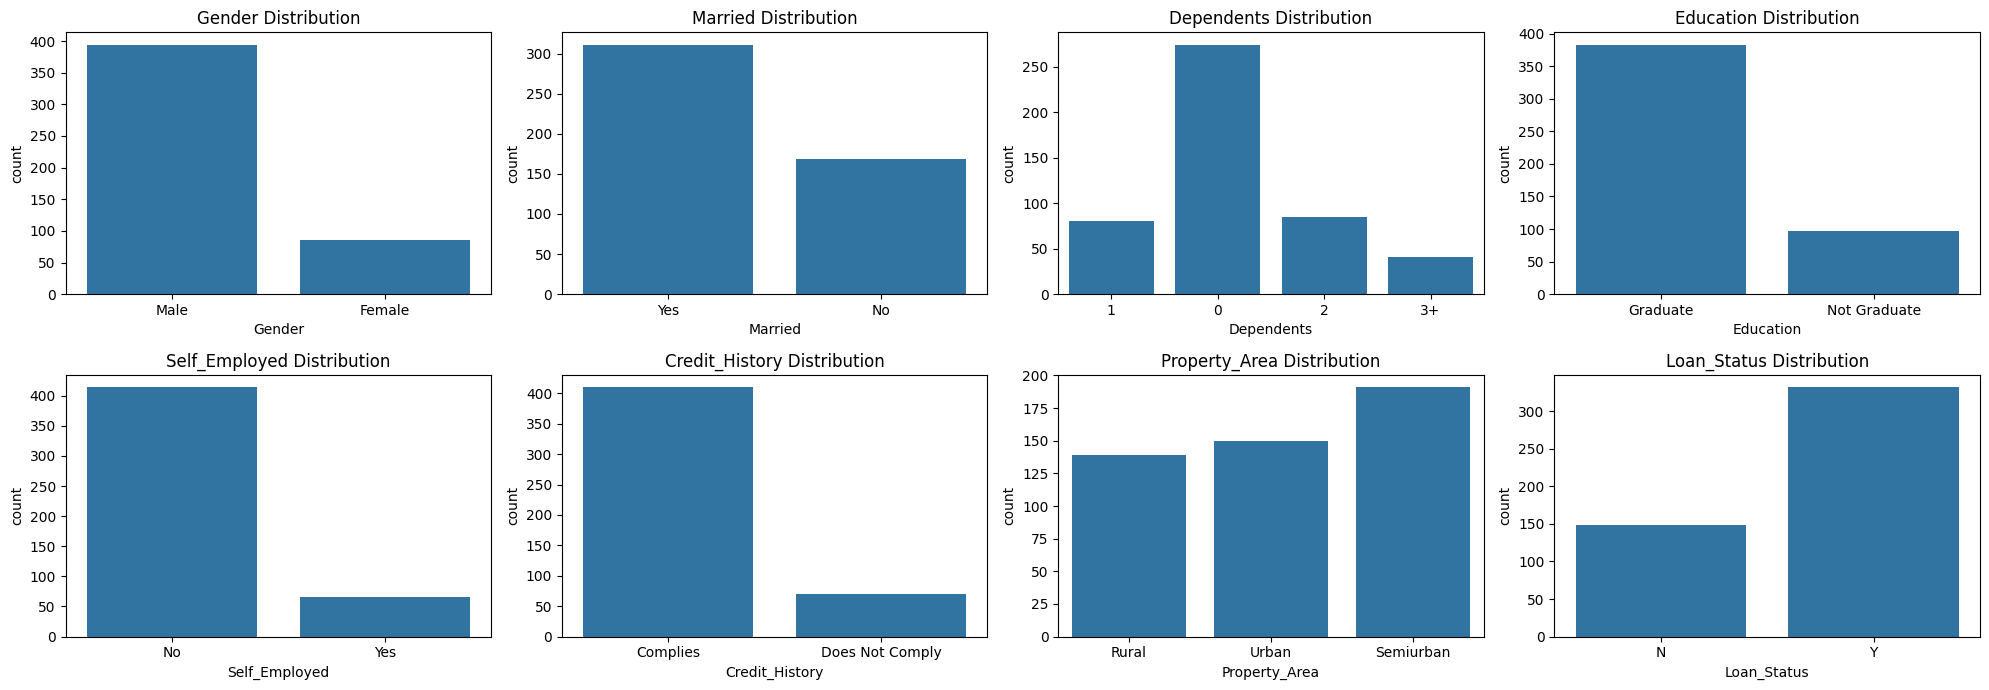

In [ ]:
eda.plot_bar_plots(data_handler.categorical_columns)

## **Data Encoding and Transformation**

In this section, we focus on converting categorical variables into numerical formats and preparing the data for model training. Many machine learning algorithms require numerical input, so categorical features (such as gender, marital status, and property area) are encoded into numbers. This process, known as data encoding, ensures that the model can interpret these features. After encoding, we perform transformations like checking and adjusting data types, removing unnecessary columns, and making sure the dataset is in a suitable format for further analysis and model development.

### **Encode categorical variables**

In this step, we define a `data_map` that converts categorical values into numerical representations. The `encode_data` method from the `DataHandler` class is used to apply these mappings to the dataset. This transformation is crucial for preparing the categorical data to be compatible with machine learning models.


In [ ]:
data_map = {
  "Gender": {"Male": 1, "Female": 0},
  "Married": {"Yes": 1, "No": 0},
  "Dependents": {"0": 0, "1": 1, "2": 2, "3+": 3},
  "Education": {"Graduate": 1, "Not Graduate": 0},
  "Self_Employed": {"Yes": 1, "No": 0},
  "Property_Area": {"Semiurban": 1, "Urban": 2, "Rural": 0},
  "Loan_Status": {"Y": 1, "N": 0}
}
data_handler.encode_data(data_map)

Encoding categorical variables...


<ipython-input-1-01d6599eeec8>:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data.replace(data_map, inplace=True)


### **Display first 10 rows of the dataset after encoding**

The `display_data` method from the `EDA` class is used to display the first 10 rows of the dataset. This allows us to inspect the dataset after encoding the categorical variables and verify that the transformation was applied correctly.


In [ ]:
eda.display_data(10)

First 10 rows of the dataset:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,2,1
5,LP001011,1,1,2,1,1,5417,4196.0,267.0,360.0,1.0,2,1
6,LP001013,1,1,0,0,0,2333,1516.0,95.0,360.0,1.0,2,1
7,LP001014,1,1,3,1,0,3036,2504.0,158.0,360.0,0.0,1,0
8,LP001018,1,1,2,1,0,4006,1526.0,168.0,360.0,1.0,2,1
9,LP001020,1,1,1,1,0,12841,10968.0,349.0,360.0,1.0,1,0
10,LP001024,1,1,2,1,0,3200,700.0,70.0,360.0,1.0,2,1


### **Check data types after encoding**

The `check_data_types` method from the `EDA` class is used to verify the data types of each column after encoding. This step ensures that the categorical features have been correctly transformed into numerical values, which are necessary for model training.


In [ ]:
eda.check_data_types()


Data Types:


,0
Loan_ID,object
Gender,int64
Married,int64
Dependents,int64
Education,int64
Self_Employed,int64
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64


### **Drop unnecessary columns**

The `drop_columns` method from the `DataHandler` class is used to remove the `Loan_ID` column from the dataset. This column is an identifier and does not provide any predictive value for the model, so it is dropped to streamline the dataset for analysis.


In [ ]:
data_handler.drop_columns(["Loan_ID"])

Dropping columns: ['Loan_ID']


## **Feature Analysis and Outlier Detection**

In this section, we conduct a thorough analysis of the features within the dataset and identify any outliers that may affect the performance of our machine learning models. Feature analysis involves examining the relationships between variables through visualizations like correlation heatmaps and various plots (histograms, boxplots) to understand the distribution of numerical features. Outlier detection is crucial, as outliers can skew results and reduce model accuracy. We apply techniques to handle these outliers appropriately, ensuring a cleaner dataset that improves the robustness of subsequent model training and evaluation.

### **Plot correlation heatmap**

The `plot_correlation_heatmap` method from the `EDA` class is used to generate a heatmap showing the correlation between numerical features in the dataset. This visualization helps identify relationships between variables, such as features that are highly correlated with each other or with the target variable (`Loan_Status`), which can be important for feature selection and model building.


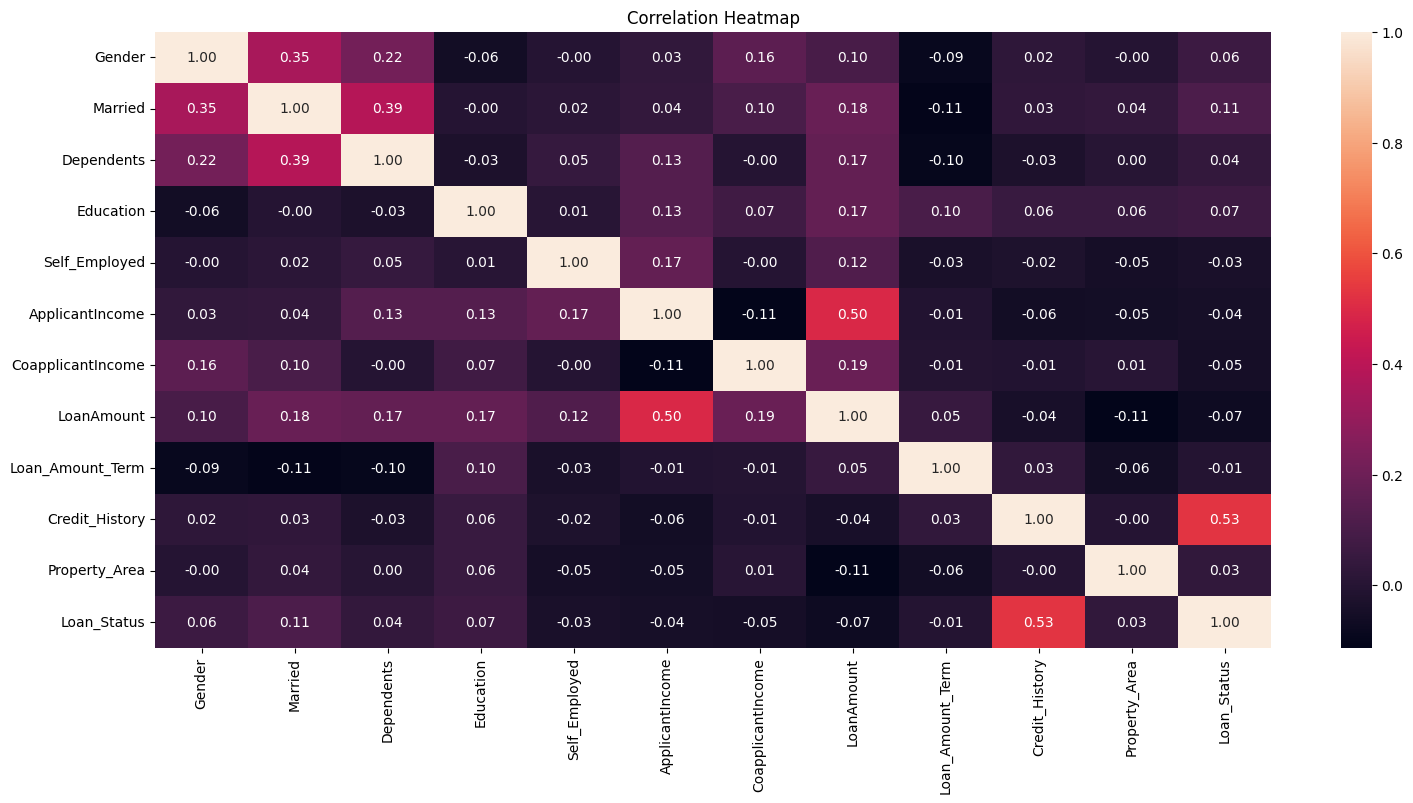

None


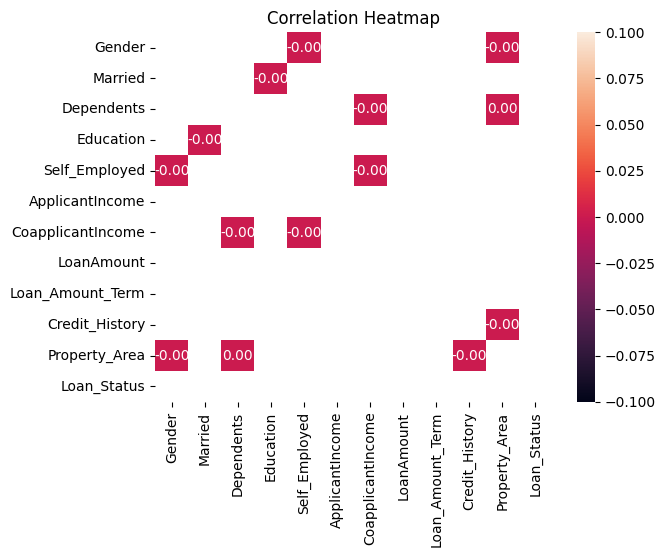

None


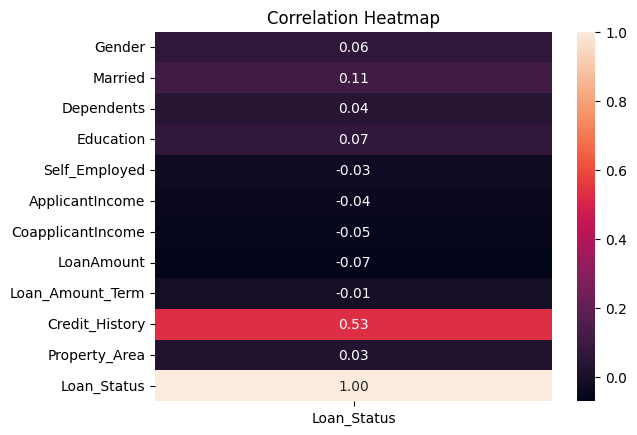

None


In [ ]:
eda.plot_correlation_heatmap()

### **Plot histograms for numerical columns**

The `plot_histograms` method from the `EDA` class is used to generate histograms for the numerical columns in the dataset. These plots help visualize the distribution of values within each numerical feature, providing insights into their spread, central tendency, and any potential skewness or outliers.


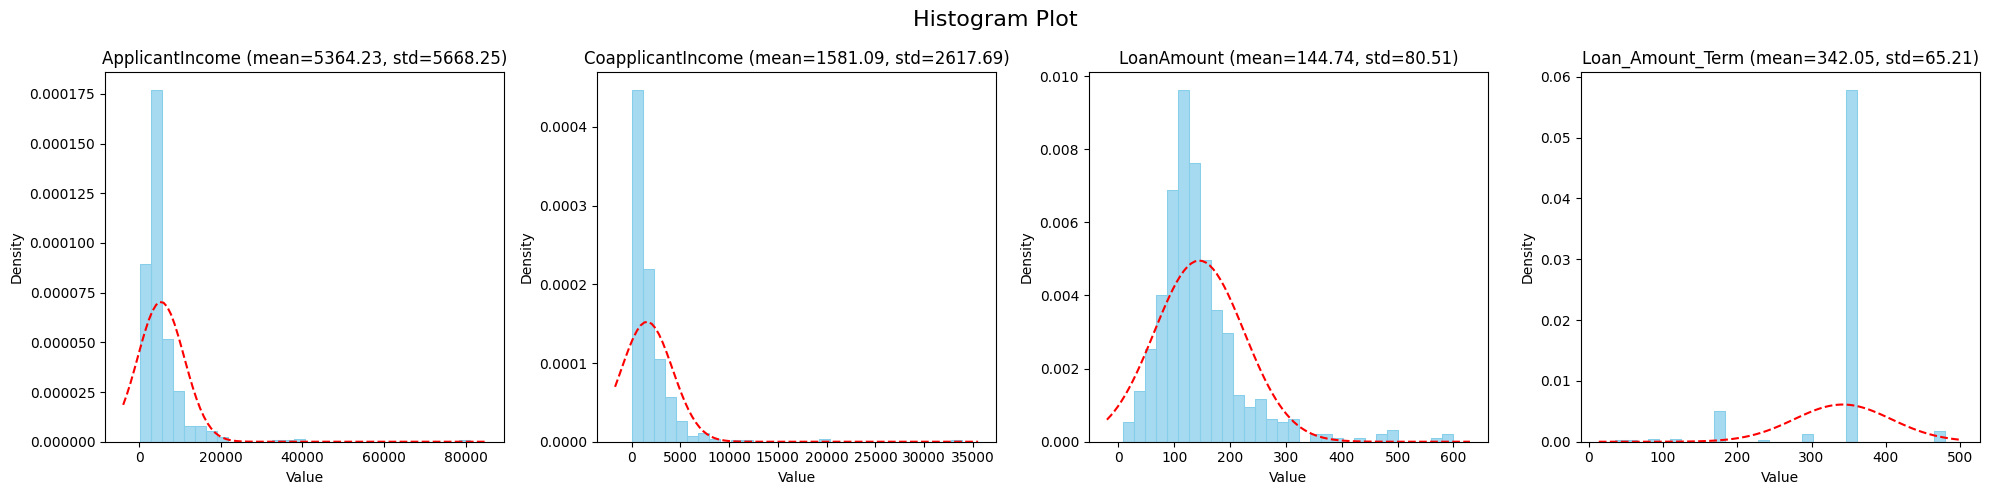

In [ ]:
eda.plot_histograms(data_handler.categorical_columns)

### **Plot boxplots for numerical columns**

The `plot_boxplots` method from the `EDA` class is used to generate boxplots for the numerical columns in the dataset. Boxplots are useful for visualizing the spread of the data, identifying the median, quartiles, and detecting potential outliers in each numerical feature.


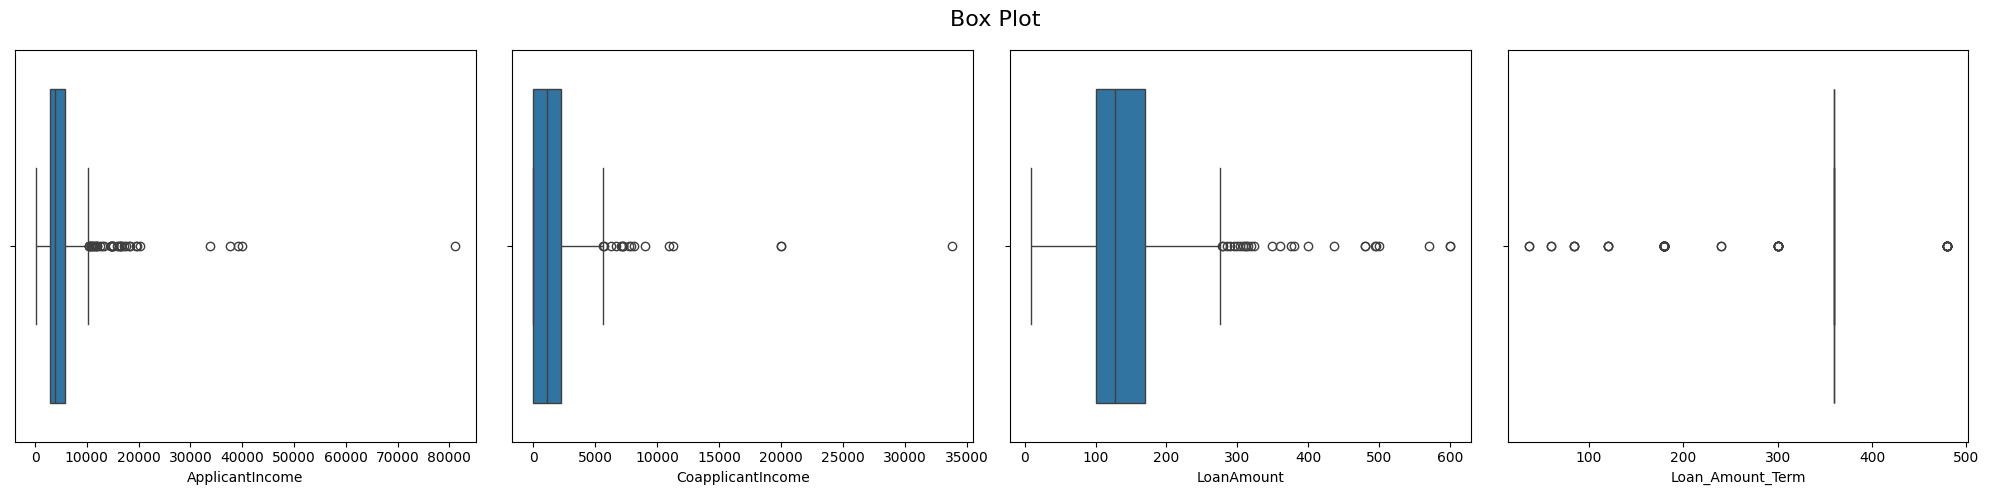

In [ ]:
eda.plot_boxplots(data_handler.categorical_columns)

### **Handle outliers in the dataset**

The `handle_outliers` method from the `DataHandler` class is used to detect and cap outliers in the dataset. Outliers can skew the results of machine learning models, so it is essential to identify and handle them to improve the performance and robustness of the models.


In [ ]:
data_handler.handle_outliers()

Detecting outliers...
Outliers handled: [('ApplicantIncome', [], -1531.875, 10283.125), ('CoapplicantIncome', [20000.0, 6250.0, 7873.0, 33837.0, 7166.0, 6666.0, 5654.0, 10968.0, 8106.0, 7210.0, 8980.0, 5701.0, 7101.0, 7750.0, 11300.0, 7250.0], -3379.875, 5633.125), ('LoanAmount', [], -5.0, 275.0), ('Loan_Amount_Term', [120.0, 84.0, 60.0, 240.0, 36.0], 360.0, 360.0)]


### **Plot boxplots after handling outliers**

The `plot_boxplots` method from the `EDA` class is used again to generate boxplots for the numerical columns after outlier handling. This step helps visualize how the data distribution has changed and ensures that extreme values have been effectively capped, reducing the impact of outliers on model training.


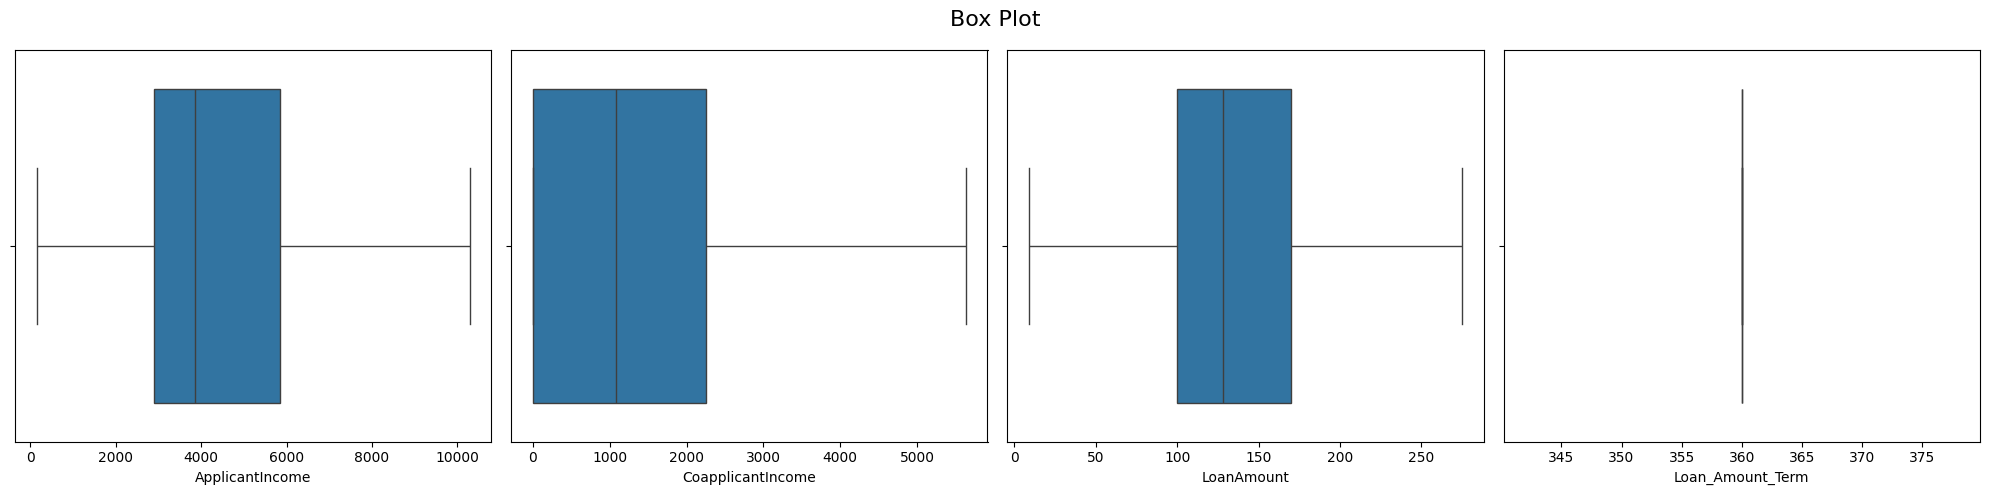

In [ ]:
eda.plot_boxplots(data_handler.categorical_columns)


## **Data Splitting and Balancing**

In this section, we focus on preparing the dataset for training and testing machine learning models by splitting it into distinct subsets. The dataset is divided into training and testing sets, ensuring that the model can be trained on one portion of the data while being validated on another. This helps in assessing the model's performance on unseen data.

Additionally, we address class imbalance within the training dataset, which can occur when one class significantly outnumbers another. We utilize techniques such as oversampling to ensure that the model receives balanced exposure to both classes, which is vital for achieving fair and accurate predictions. Balancing the dataset enhances the model's ability to generalize, ultimately leading to improved performance in loan status predictions.

### **Split the dataset into training and testing sets**

The `split_data` method from the `DataHandler` class is used to divide the dataset into training and testing sets. The target variable is `Loan_Status`. The training set will be used to train the machine learning models, while the testing set will be used to evaluate their performance on unseen data. This step ensures that the model is tested on data it hasn't seen before, helping to avoid overfitting.


In [ ]:
x_train, x_test, y_train, y_test = data_handler.split_data("Loan_Status")

Data split into train and test sets.


### **Balance the training dataset**

The `balance_classes` method from the `DataHandler` class is used to balance the classes in the training dataset by oversampling the minority class. This step is crucial when dealing with imbalanced datasets, ensuring that the model does not become biased towards the majority class and improving its ability to accurately predict both classes.


In [ ]:
x_train, y_train = data_handler.balance_classes(x_train, y_train)

Before oversample: 264 120
After oversample: 264 264


## **Model Management and Evaluation**

In this section, we focus on the organization, training, and evaluation of various machine learning models used for loan approval prediction. This involves initializing the ModelManager class, which serves as a central hub for managing multiple machine learning algorithms. The models are added to this manager, allowing for streamlined training and evaluation processes.

We systematically train all selected models on the training dataset and evaluate their performance using metrics such as accuracy, precision, recall, and F1 score. This evaluation is critical for understanding how well each model performs on both the training and validation datasets. By comparing the performance of different models, we can identify the most effective algorithms for making accurate loan approval predictions.

The section concludes with visualizations of model performance metrics, which provide insights into the strengths and weaknesses of each model, guiding decisions on which model to deploy in practice.

### **Initialize the ModelManager**

The `ModelManager` class is initialized to manage the machine learning models. This class will be responsible for adding, training, and evaluating multiple models, streamlining the process of model management and comparison throughout the machine learning workflow.


In [ ]:
# Initialize the model manager
model_manager = ModelManager()

### **Add machine learning models to the ModelManager**

In this step, various machine learning models are added to the `ModelManager`. These models include popular classifiers such as K-Nearest Neighbors (KNN), Logistic Regression, Random Forest, Decision Tree, Support Vector Machine (SVM), and ensemble methods like XGBoost, LightGBM, CatBoost, and Gradient Boosting. This setup allows for easy training and evaluation of multiple models for the loan approval prediction task.


In [ ]:
# Add models to the manager
model_manager.add_model('KNN', KNeighborsClassifier())
model_manager.add_model('Logistic Regression', LogisticRegression(max_iter=1000))
model_manager.add_model('Random Forest', RandomForestClassifier())
model_manager.add_model('Decision Tree', DecisionTreeClassifier())
model_manager.add_model('SVM', SVC(probability=True))
model_manager.add_model('XGBoost', XGBClassifier())
model_manager.add_model('LightGBM', LGBMClassifier(verbosity=-1))
model_manager.add_model('CatBoost', CatBoostClassifier(logging_level='Silent'))
model_manager.add_model('Naive Bayes', GaussianNB())
model_manager.add_model('Gradient Boosting', GradientBoostingClassifier())

### **Train all models**

The `train_all_models` method from the `ModelManager` class is used to train all the machine learning models that were added to the manager. Each model is trained using the training dataset (`x_train` and `y_train`), preparing them for evaluation on the test data.


In [ ]:
# Train all models
model_manager.train_all_models(x_train, y_train)

KNN trained successfully.
Logistic Regression trained successfully.
Random Forest trained successfully.
Decision Tree trained successfully.
SVM trained successfully.
XGBoost trained successfully.
LightGBM trained successfully.
CatBoost trained successfully.
Naive Bayes trained successfully.
Gradient Boosting trained successfully.


### **Evaluate all models**

The `evaluate_all_models` method from the `ModelManager` class is used to evaluate the performance of all trained models. Each model is tested on both the training and testing datasets (`x_train`, `y_train`, `x_test`, `y_test`), and key metrics such as accuracy, precision, recall, and F1-score are calculated. This step helps compare the performance of different models and identify the best one for predicting loan approvals.



Evaluating KNN...
Model : KNN
Training Accuracy  : 0.7652
Validation Accuracy: 0.4896
Accuracy Difference: 0.2756
Precision          : 0.4852
Recall             : 0.4821
F1 Score           : 0.4639

Confusion Matrix

                  Predicted
                  0       1
            0    13      15
    Actual  1    34      34
        


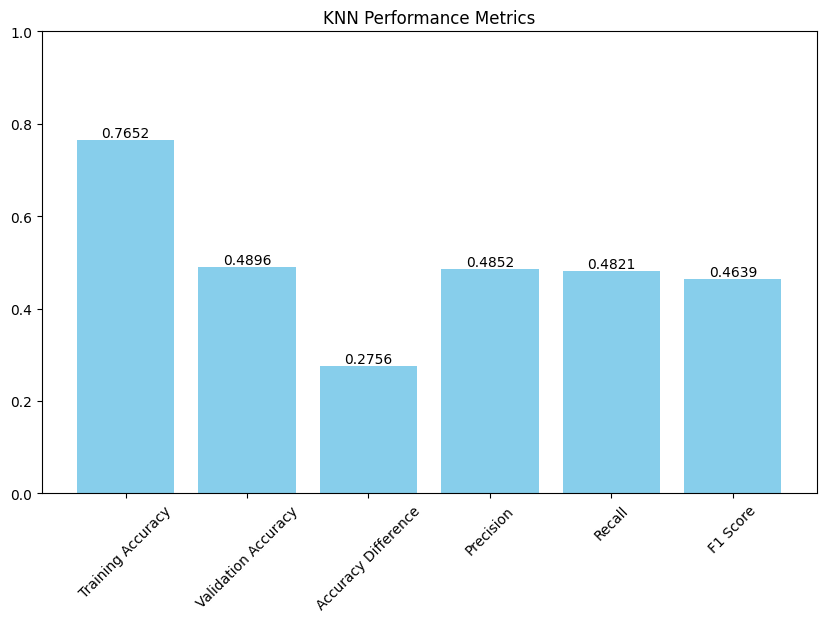


Evaluating Logistic Regression...
Model : Logistic Regression
Training Accuracy  : 0.7538
Validation Accuracy: 0.8125
Accuracy Difference: -0.0587
Precision          : 0.7991
Recall             : 0.7206
F1 Score           : 0.7427

Confusion Matrix

                  Predicted
                  0       1
            0    14      14
    Actual  1    4      64
        


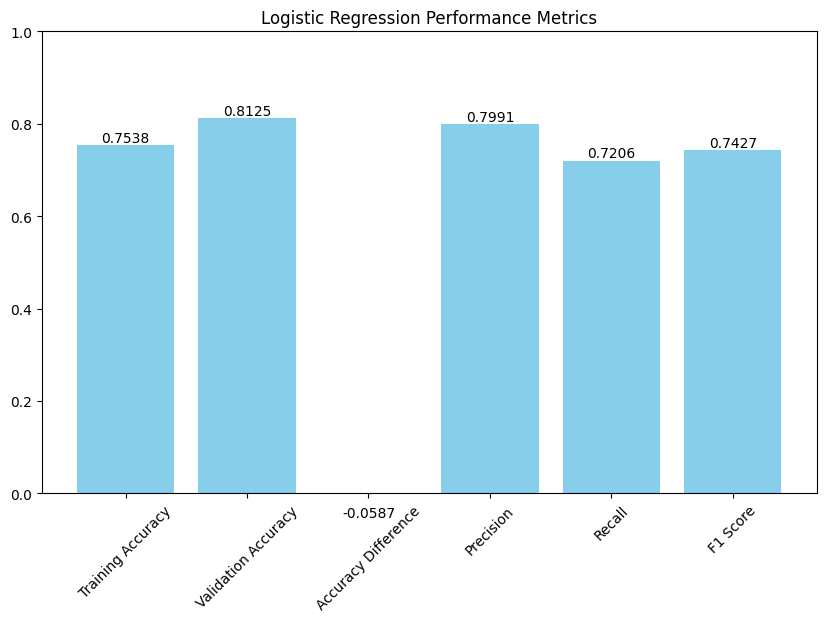


Evaluating Random Forest...
Model : Random Forest
Training Accuracy  : 1.0000
Validation Accuracy: 0.8125
Accuracy Difference: 0.1875
Precision          : 0.7826
Recall             : 0.7416
F1 Score           : 0.7566

Confusion Matrix

                  Predicted
                  0       1
            0    16      12
    Actual  1    6      62
        


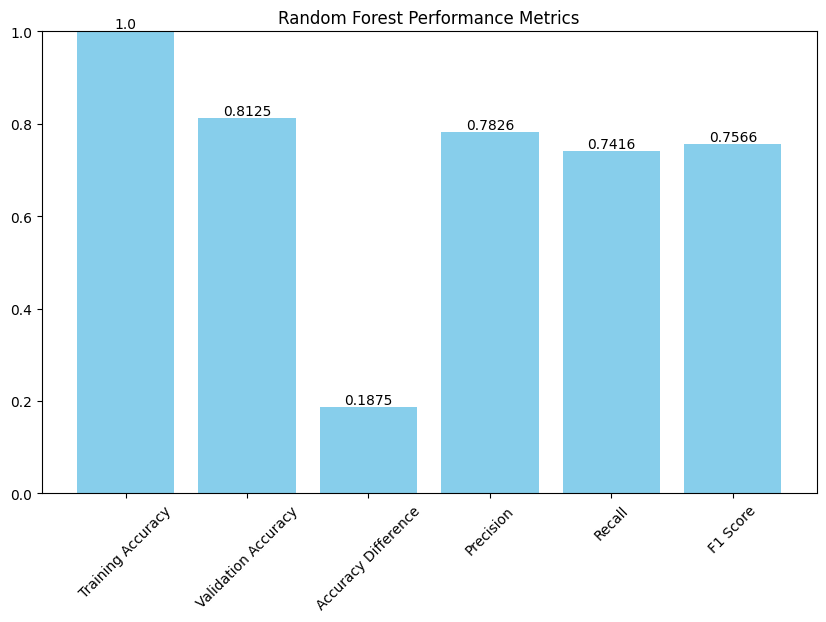


Evaluating Decision Tree...
Model : Decision Tree
Training Accuracy  : 1.0000
Validation Accuracy: 0.7188
Accuracy Difference: 0.2812
Precision          : 0.6544
Recall             : 0.6439
F1 Score           : 0.6482

Confusion Matrix

                  Predicted
                  0       1
            0    13      15
    Actual  1    12      56
        


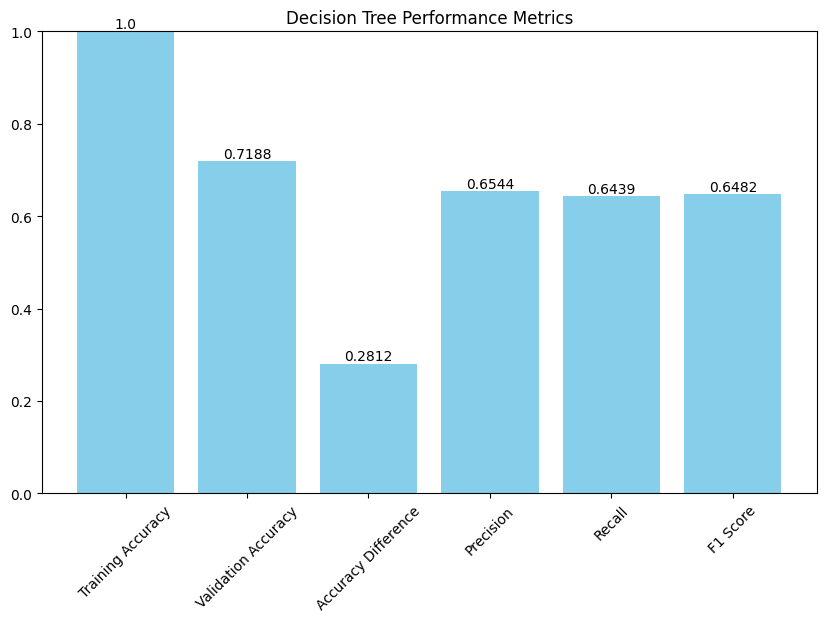


Evaluating SVM...
Model : SVM
Training Accuracy  : 0.5530
Validation Accuracy: 0.4896
Accuracy Difference: 0.0634
Precision          : 0.5394
Recall             : 0.5452
F1 Score           : 0.4851

Confusion Matrix

                  Predicted
                  0       1
            0    19      9
    Actual  1    40      28
        


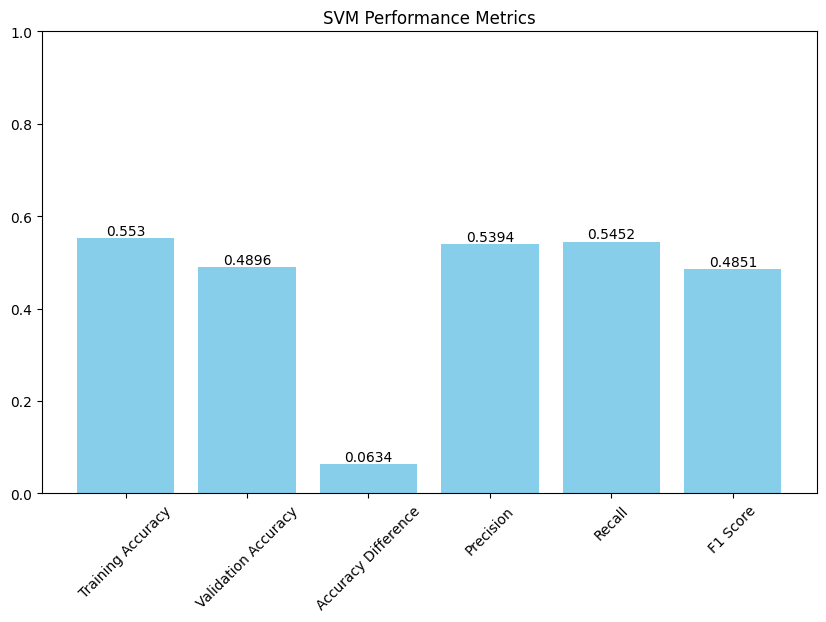


Evaluating XGBoost...
Model : XGBoost
Training Accuracy  : 1.0000
Validation Accuracy: 0.7604
Accuracy Difference: 0.2396
Precision          : 0.7093
Recall             : 0.7048
F1 Score           : 0.7070

Confusion Matrix

                  Predicted
                  0       1
            0    16      12
    Actual  1    11      57
        


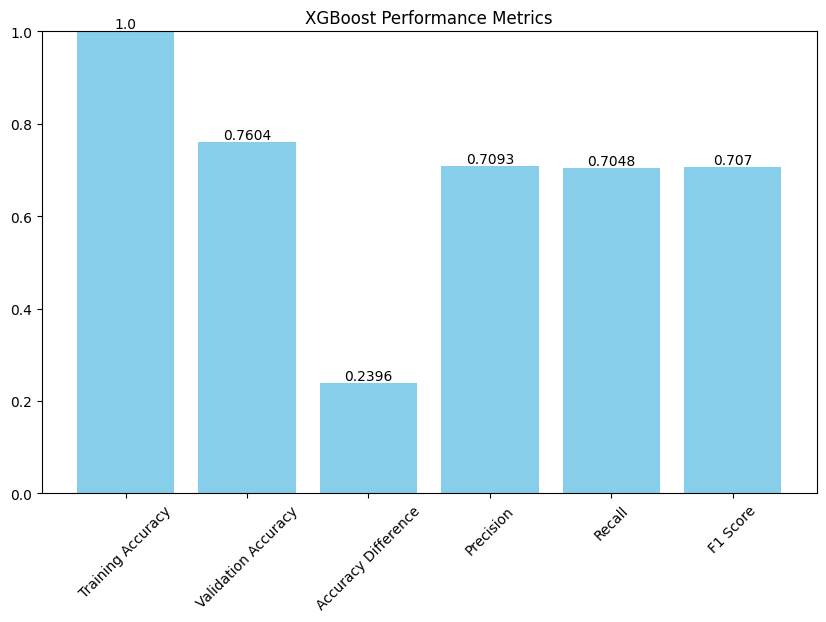


Evaluating LightGBM...
Model : LightGBM
Training Accuracy  : 0.9981
Validation Accuracy: 0.7812
Accuracy Difference: 0.2169
Precision          : 0.7351
Recall             : 0.7300
F1 Score           : 0.7324

Confusion Matrix

                  Predicted
                  0       1
            0    17      11
    Actual  1    10      58
        


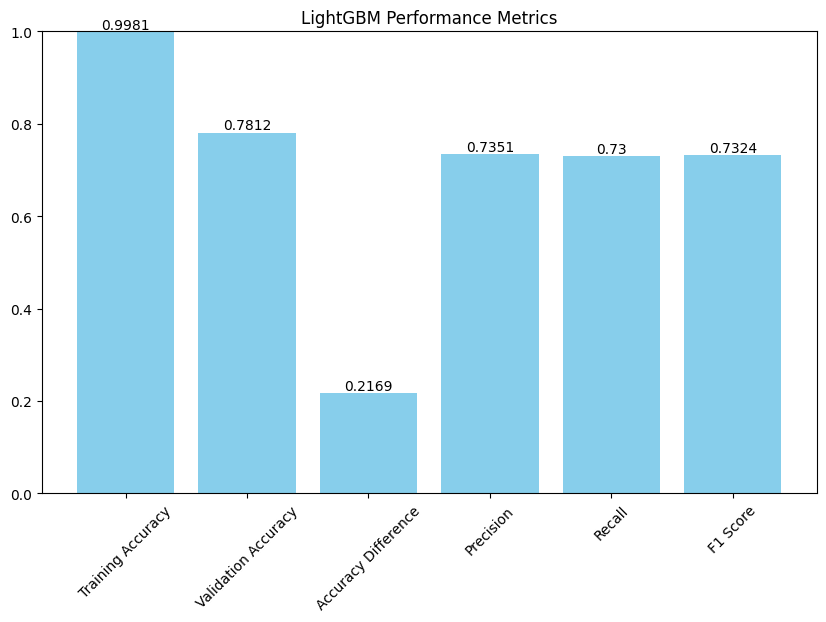


Evaluating CatBoost...
Model : CatBoost
Training Accuracy  : 0.9848
Validation Accuracy: 0.7917
Accuracy Difference: 0.1932
Precision          : 0.7500
Recall             : 0.7269
F1 Score           : 0.7363

Confusion Matrix

                  Predicted
                  0       1
            0    16      12
    Actual  1    8      60
        


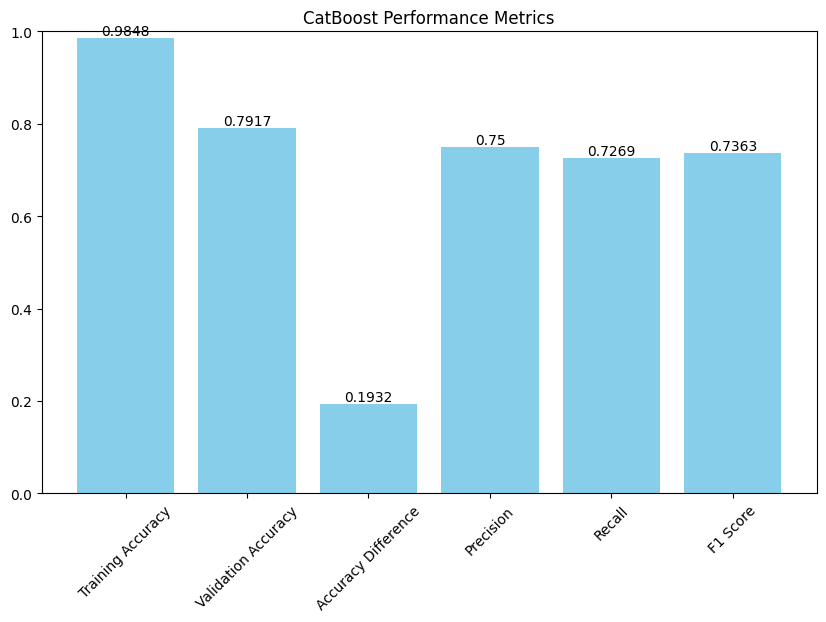


Evaluating Naive Bayes...
Model : Naive Bayes
Training Accuracy  : 0.7159
Validation Accuracy: 0.8125
Accuracy Difference: -0.0966
Precision          : 0.8310
Recall             : 0.6996
F1 Score           : 0.7257

Confusion Matrix

                  Predicted
                  0       1
            0    12      16
    Actual  1    2      66
        


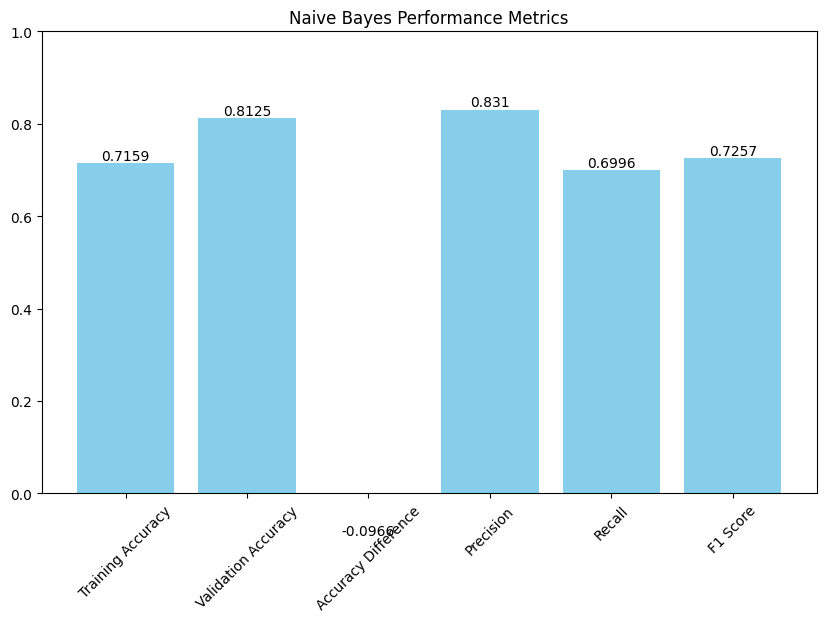


Evaluating Gradient Boosting...
Model : Gradient Boosting
Training Accuracy  : 0.9186
Validation Accuracy: 0.7396
Accuracy Difference: 0.1790
Precision          : 0.6896
Recall             : 0.7006
F1 Score           : 0.6942

Confusion Matrix

                  Predicted
                  0       1
            0    17      11
    Actual  1    14      54
        


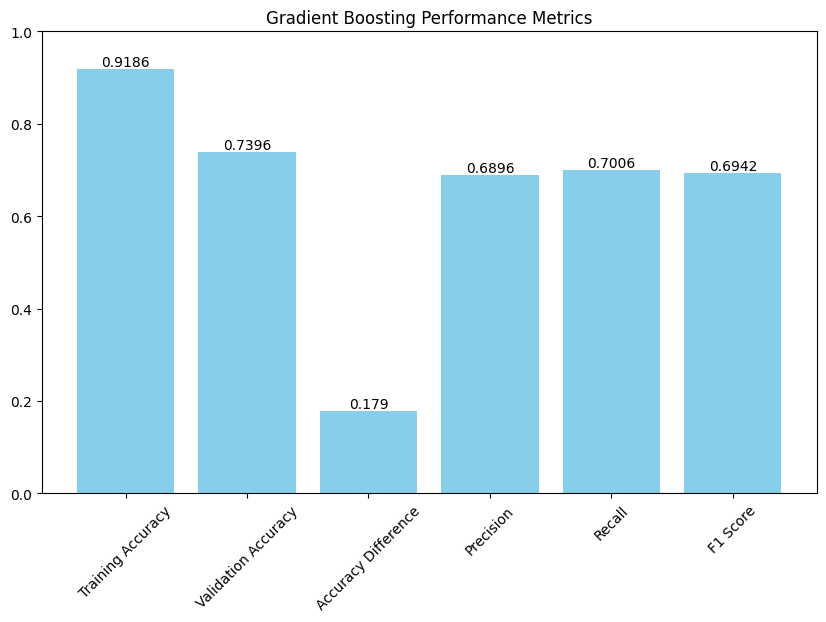

In [ ]:
# Evaluate all models
model_manager.evaluate_all_models(x_train, y_train, x_test, y_test)

### **Plot all model performance metrics**

The `plot_all_metrics` method from the `ModelManager` class is used to visualize the performance of all trained models. This method generates bar charts for various metrics (such as accuracy, precision, recall, and F1-score) across all models, allowing for easy comparison of their performance and helping to select the most suitable model for loan approval prediction.


Plotting train_accuracy comparison...


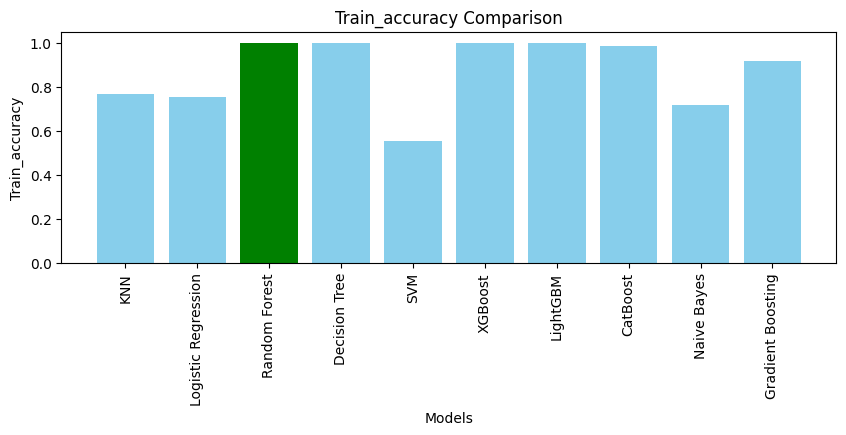

Plotting val_accuracy comparison...


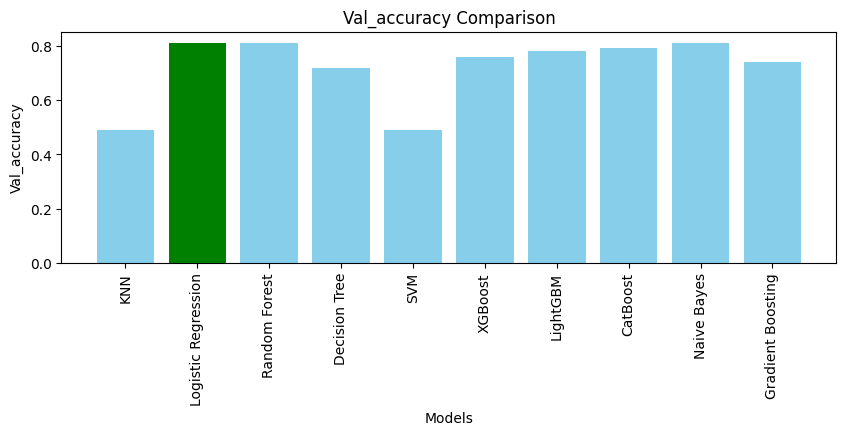

Plotting accuracy_diff comparison...


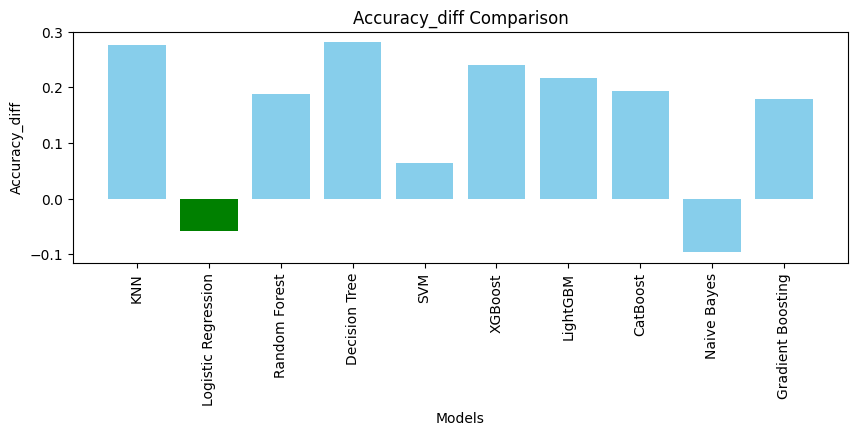

Plotting precision comparison...


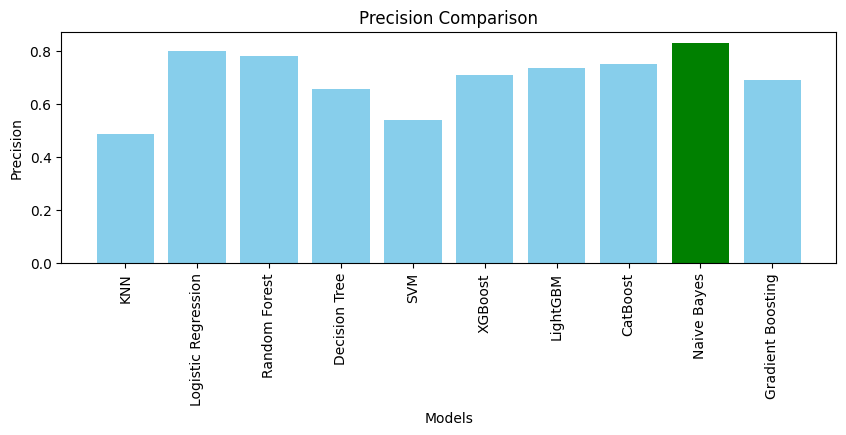

Plotting recall comparison...


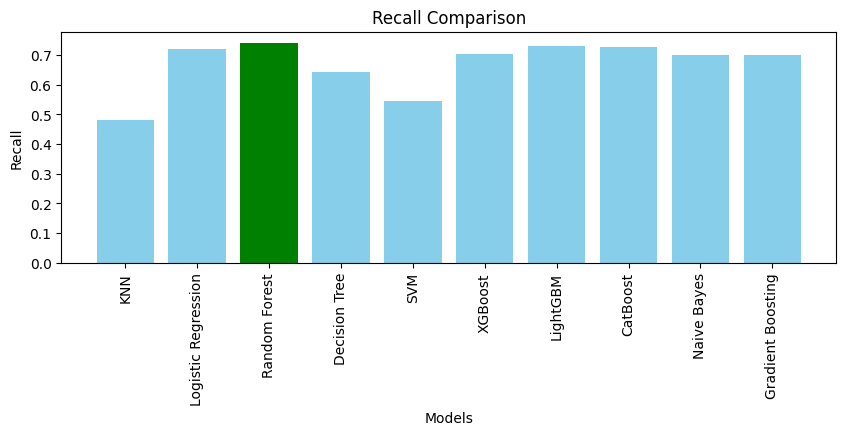

Plotting f1 comparison...


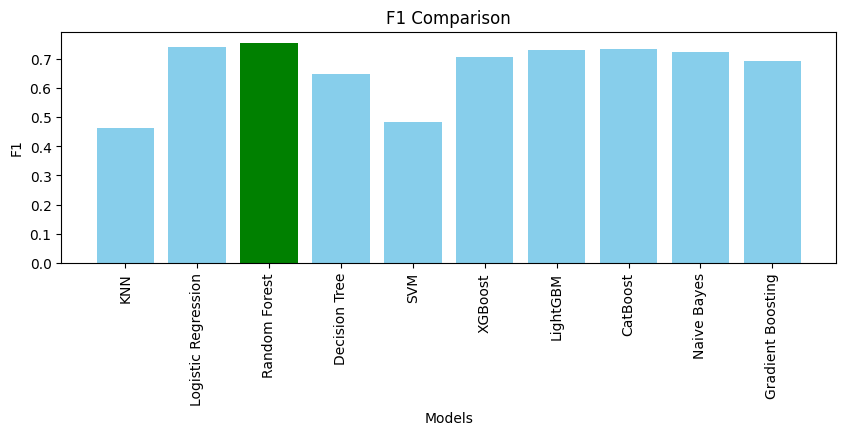

In [ ]:
model_manager.plot_all_metrics()


## **Interactive Model Predictions**

This section focuses on creating an interactive interface that allows users to input their data and receive predictions about loan approval status based on the trained models. Using the UserInteractionManager class, we facilitate user engagement by mapping user inputs to the corresponding features required by the models.

The interactive setup enables users to enter various attributes related to the loan application, such as applicant details and financial information. Once the input is collected, the system makes predictions using all available models, providing a comprehensive overview of potential loan approval statuses.

### **Set up user interaction and mapping for predictions**

In this cell, the `data_map` is defined to map categorical values for the input features, such as `Gender`, `Married`, and `Credit_History`. The `UserInteractionManager` class is then initialized with the models from `ModelManager` and the `data_map`. This setup allows for user-friendly input collection and prediction using various models.


- **ApplicantIncome**: Min: 150.0 – Max: 10283.125
- **CoapplicantIncome**: Min: 0.0 – Max: 5633.125
- **LoanAmount**: Min: 9.0 – Max: 275.0
- **Loan_Amount_Term**: Fixed at 360.0

In [ ]:
data_map = data_handler.data_map
data_map['Credit_History'] = {"Yes":1,"No":0}

user_manager = UserInteractionManager(model_manager.get_all_models(), data_map)

### **Get user input for prediction**

Here, the `get_user_input` method from the `UserInteractionManager` class is called to collect user input for all relevant features, such as `Gender`, `Married`, `Dependents`, and more. The user provides responses for each feature, which are then used for model predictions.


In [ ]:
# Get user input and predict with models
user_input = user_manager.get_user_input()


Enter Gender (Male, Female or 'q' to quit): Male
Enter Married (Yes, No or 'q' to quit): Yes
Enter Dependents (0, 1, 2, 3+ or 'q' to quit): 0
Enter Education (Graduate, Not Graduate or 'q' to quit): Graduate
Enter Self_Employed (Yes, No or 'q' to quit): No 
Enter ApplicantIncome (numeric value or 'q' to quit): 4000
Enter CoapplicantIncome (numeric value or 'q' to quit): 1500
Enter LoanAmount (numeric value or 'q' to quit): 200
Enter Loan_Amount_Term (numeric value or 'q' to quit): 360
Enter Credit_History (Yes, No or 'q' to quit): Yes
Enter Property_Area (Semiurban, Urban, Rural or 'q' to quit): Rural 


### **Predict loan status with all models**

The `predict_with_models` method from the `UserInteractionManager` class is used to make predictions with all the models in the `ModelManager`. Based on the user input, each model predicts whether the loan will be approved or not, and the results are displayed for comparison.


In [ ]:
user_manager.predict_with_models(user_input)

KNN: Loan Status Prediction - Approved
Logistic Regression: Loan Status Prediction - Approved
Random Forest: Loan Status Prediction - Approved
Decision Tree: Loan Status Prediction - Approved
SVM: Loan Status Prediction - Approved
XGBoost: Loan Status Prediction - Approved
LightGBM: Loan Status Prediction - Approved
CatBoost: Loan Status Prediction - Approved
Naive Bayes: Loan Status Prediction - Approved
Gradient Boosting: Loan Status Prediction - Approved


### **Predict loan status with a specific model: Logistic Regression**

In this cell, the `predict_with_model` method is used to make a prediction with **Logistic Regression**, which was selected as the final model for the loan status prediction task.

### Why **Logistic Regression**?

- **Balanced Performance**: Logistic Regression offers the best balance across key metrics such as accuracy, precision, recall, and F1-score. It generalizes well to new data, as indicated by its similar training and validation accuracy, with an accuracy difference of just -5.87%, meaning it doesn't overfit.
  
- **High Validation Accuracy**: With a validation accuracy of **81.25%**, Logistic Regression performs consistently across both the training and test datasets.

- **Precision and Recall**: It provides a good balance between precision (79.91%) and recall (72.06%), making it well-suited for loan approval prediction where both false positives (incorrect approvals) and false negatives (missed approvals) need to be minimized.

- **Simple and Interpretable**: Logistic Regression is a simpler, more interpretable model compared to complex models like Random Forest, XGBoost, and CatBoost. This makes it easier to understand and explain the model's predictions, which is crucial in financial applications such as loan approvals.


In [ ]:
user_manager.predict_with_model("Logistic Regression", user_input)

Logistic Regression: Loan Status Prediction - Approved


In [ ]:
import joblib

# Fetching the Logistic Regression model
logistic_regression_model = model_manager.get_all_models()["Logistic Regression"]

# Saving the model
joblib.dump(logistic_regression_model, 'logistic_regression_model.pkl')

print("Model saved successfully as logistic_regression_model.pkl")


Model saved successfully as logistic_regression_model.pkl


## **Conclusion**

In this project, we developed a machine learning pipeline to predict loan approval status using various classification algorithms. Starting with data preprocessing, we handled missing values, encoded categorical variables, and balanced the dataset to address class imbalance. Through Exploratory Data Analysis (EDA), we gained insights into the distributions of numerical and categorical features, as well as the relationships between variables.

### Key Steps:
1. **Data Preprocessing**: We cleaned the dataset by handling missing values and encoding categorical features, ensuring it was ready for modeling.
2. **Exploratory Data Analysis (EDA)**: EDA helped in understanding the structure and relationships within the data, revealing patterns and potential outliers.
3. **Model Selection**: Several models were trained and evaluated, including Logistic Regression, Random Forest, XGBoost, CatBoost, and Naive Bayes. Each model was assessed using key performance metrics such as accuracy, precision, recall, and F1-score.
4. **Model Evaluation**: Logistic Regression emerged as the top-performing model, offering a well-balanced performance across all evaluation metrics. It demonstrated high validation accuracy and low overfitting, making it suitable for deployment in a loan approval prediction system.

### Why Logistic Regression?
Logistic Regression was chosen as the final model for the following reasons:
- **High Validation Accuracy**: Logistic Regression achieved a validation accuracy of **81.25%**, with a minimal accuracy difference between training and validation, showing good generalization.
- **Balanced Metrics**: It showed a strong balance between precision, recall, and F1-score, minimizing both false positives and false negatives, which is crucial in financial decision-making.
- **Simplicity and Interpretability**: Logistic Regression is a simpler, more interpretable model compared to more complex models like XGBoost or CatBoost. This makes it ideal for deployment in financial applications, where transparency and interpretability are important.

### Final Prediction:
Using the selected Logistic Regression model, we developed a user-friendly interface that allows for interactive loan status predictions based on user input. The model effectively predicts whether a loan will be approved or not, providing valuable insights for the decision-making process in a lending scenario.

### Why We Chose F1 Score:

The F1 score was used as a key evaluation metric because of its ability to balance precision and recall, particularly in imbalanced datasets. In the context of loan approval prediction, both types of errors are important:

- **False Positives** (incorrect loan approvals) can lead to financial losses. **Precision** measures the proportion of correctly predicted positive cases out of all predicted positives, so it focuses on minimizing false positives.

- **False Negatives** (incorrect loan rejections) can lead to missed business opportunities. **Recall** measures the proportion of correctly predicted positive cases out of all actual positives, so it focuses on minimizing false negatives.

By using the F1 score, which is the harmonic mean of precision and recall, we aim for overall error reduction. This ensures that both false positives and false negatives are minimized, which is crucial for loan approval prediction where the costs of incorrect decisions are significant on both sides.

### Future Work:
While Logistic Regression performed well, further improvements could be made by:
- Exploring additional feature engineering techniques.
- Tuning hyperparameters for models such as XGBoost and LightGBM to potentially improve their performance.
- Incorporating more advanced algorithms or ensemble techniques for boosting model performance.

Overall, this project has demonstrated the feasibility of using machine learning to predict loan approval, with Logistic Regression being the optimal model for the task due to its reliability, accuracy, and interpretability.
